In [12]:
import numpy as np

import tqdm

import matplotlib.pyplot as plt
plt.style.use("ggplot")
from torchvision import transforms
import os
from torch.utils.data import DataLoader
from src.data.our_kaggle_food_dataset import KaggleFoodDataset
from src.models.model_utils import *


current_dir = r"C:\Users\Karlu\Desktop\DeliNet"
food_dir = os.path.join(current_dir,'data','processed','KaggleFoodDataset')
csv_file_path = os.path.join(food_dir, 'data.csv')
image_dir = os.path.join(food_dir,'images')
batch_size = 100
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224, 224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

data_set_with_transf = KaggleFoodDataset(csv_file=csv_file_path, image_dir=image_dir,
                                         transform=preprocess, train=False, train_split=0.9)
data_set_NO_transf = KaggleFoodDataset(csv_file=csv_file_path, image_dir=image_dir,
                                         transform=None, train=False, train_split=0.9)

num_workers = 0 if os.name=="nt" else 6 #os.cpu_count()# set num workers to all cores if not windows
#dataloader_train = DataLoader(food_dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader_test = DataLoader(data_set_with_transf, batch_size=batch_size, shuffle=False, num_workers=num_workers)


#torch.set_default_dtype(torch.float16)

d = "cuda"

vision_model = torch.load(r"C:\Users\Karlu\Desktop\DeliNet\src\models\saved_models\ResNet50_AND_DistilBert_mono_KNNtest\ResNet50.pt")
text_model = torch.load(r"C:\Users\Karlu\Desktop\DeliNet\src\models\saved_models\ResNet50_AND_DistilBert_mono_KNNtest\DistilBert_mono.pt")



In [2]:
with torch.no_grad():
    img_embs = []
    text_embs = []
    for i, (image, text) in enumerate(tqdm.tqdm(dataloader_test)):
        img_emb = vision_model(image.to(d))
        text_emb = text_model(text)
        img_embs.append(img_emb)
        text_embs.append(text_emb)
    
    
    img_embs = torch.cat(img_embs, dim=0)
    text_embs = torch.cat(text_embs, dim=0)
    
    img_embs = img_embs / torch.linalg.norm(img_embs, axis=1, keepdim=True)
    text_embs = text_embs / torch.linalg.norm(text_embs, axis=1, keepdim=True)

100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


In [3]:
img_embs = img_embs.cpu().numpy()
text_embs = text_embs.cpu().numpy()

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_score_max = -1 #this is the minimum possible score

for n_clusters in range(2, 50):
  Kmeans_model_text = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=1)
  labels = Kmeans_model_text.fit_predict(text_embs)
  sil_score = silhouette_score(text_embs, labels)
  print("The average silhouette score for %i clusters is %0.2f" %(n_clusters, sil_score))
  if sil_score > sil_score_max:
    sil_score_max = sil_score
    best_n_clusters = n_clusters
    
print(f"best KNN had {best_n_clusters} clusters with a sil score of {sil_score_max:.3f}")

The average silhouette score for 2 clusters is 0.25
The average silhouette score for 3 clusters is 0.31
The average silhouette score for 4 clusters is 0.36
The average silhouette score for 5 clusters is 0.42
The average silhouette score for 6 clusters is 0.45
The average silhouette score for 7 clusters is 0.43
The average silhouette score for 8 clusters is 0.44
The average silhouette score for 9 clusters is 0.43
The average silhouette score for 10 clusters is 0.40
The average silhouette score for 11 clusters is 0.42
The average silhouette score for 12 clusters is 0.41
The average silhouette score for 13 clusters is 0.40
The average silhouette score for 14 clusters is 0.39
The average silhouette score for 15 clusters is 0.40
The average silhouette score for 16 clusters is 0.39
The average silhouette score for 17 clusters is 0.39
The average silhouette score for 18 clusters is 0.38
The average silhouette score for 19 clusters is 0.38
The average silhouette score for 20 clusters is 0.39
T

In [28]:
n_clusters = 10
n_init = 20
print(f"fitting {n_init} KNNs with {n_clusters} clusters each and using the best!")
Kmeans_model_text = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=n_init)
Kmeans_model_text = Kmeans_model_text.fit(text_embs)
cluster_pred = Kmeans_model_text.predict(text_embs)
print("num of memnbers in each cluster", np.unique(cluster_pred, return_counts=True)[1])

fitting 20 KNNs with 10 clusters each and using the best!
num of memnbers in each cluster [ 84 183  99  88 170 146 169 118 190 100]


In [6]:
dist_to_cluster = Kmeans_model_text.transform(text_embs)


top_x_of_each_cluster = 3

for cluster in range(n_clusters):
    cur_cluster = dist_to_cluster[:, cluster]
    cur_cluster_arg_sort = np.argsort(cur_cluster)
    best_idx = cur_cluster_arg_sort[:top_x_of_each_cluster]
    worst_idx = cur_cluster_arg_sort[-top_x_of_each_cluster:]

    print("\n**************************************************")
    print(f"cluster {cluster} closests titles:")
    print("BEST")
    for idx in best_idx: print(data_set_NO_transf[idx][1][0])
    print("WORST")
    for idx in worst_idx: print(data_set_NO_transf[idx][1][0]) 


    



**************************************************
cluster 0 closests titles:
BEST
Moroccan Braised Beef
Indian-Spiced Chicken Kebabs with Cilantro-Mint Chutney
Duck Stuffed with Chicken Liver, Candied Orange, and Pears
WORST
Goat Cheese and Herb Souffles
Blueberry Lemon Crumbles
Homemade Flour Tortillas

**************************************************
cluster 1 closests titles:
BEST
Cranberry Eggnog Tart
Honeyed Walnut Tart
Churros (Deep Fried Dough Spirals)
WORST
Sweet-and-Sour Baby Carrots
Pan-Seared Venison with Rosemary and Dried Cherries
Confit Duck Leg Pozole

**************************************************
cluster 2 closests titles:
BEST
Spaghetti with Anchovies, Olives, and Toasted Bread Crumbs
Chicken and Green Bean Coconut Curry
Pasta with Anchovies, Currants, Fennel, and Pine Nuts
WORST
Hazelnut Paris-Brest
Grilled Pineapple
Poached Pears with Quince Paste in Parmesan Cloaks

**************************************************
cluster 3 closests titles:
BEST
Pasta and

In [7]:
sil_score_max = -1 #this is the minimum possible score

for n_clusters in range(2, 50):
  Kmeans_model_img = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=1)
  labels = Kmeans_model_img.fit_predict(img_embs)
  sil_score = silhouette_score(img_embs, labels)
  print("The average silhouette score for %i clusters is %0.2f" %(n_clusters, sil_score))
  if sil_score > sil_score_max:
    sil_score_max = sil_score
    best_n_clusters = n_clusters
print(f"best KNN had {best_n_clusters} clusters with a sil score of {sil_score_max:.3f}")

The average silhouette score for 2 clusters is 0.21
The average silhouette score for 3 clusters is 0.26
The average silhouette score for 4 clusters is 0.32
The average silhouette score for 5 clusters is 0.37
The average silhouette score for 6 clusters is 0.39
The average silhouette score for 7 clusters is 0.37
The average silhouette score for 8 clusters is 0.36
The average silhouette score for 9 clusters is 0.34
The average silhouette score for 10 clusters is 0.33
The average silhouette score for 11 clusters is 0.33
The average silhouette score for 12 clusters is 0.32
The average silhouette score for 13 clusters is 0.33
The average silhouette score for 14 clusters is 0.33
The average silhouette score for 15 clusters is 0.32
The average silhouette score for 16 clusters is 0.30
The average silhouette score for 17 clusters is 0.31
The average silhouette score for 18 clusters is 0.30
The average silhouette score for 19 clusters is 0.31
The average silhouette score for 20 clusters is 0.31
T

In [29]:
n_clusters = 10
n_init = 20
print(f"fitting {n_init} KNNs with {n_clusters} clusters each and using the best!")
Kmeans_model_img = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=n_init)
Kmeans_model_img = Kmeans_model_img.fit(img_embs)
cluster_pred = Kmeans_model_img.predict(img_embs)
print("num of memnbers in each cluster", np.unique(cluster_pred, return_counts=True)[1])

fitting 20 KNNs with 10 clusters each and using the best!
num of memnbers in each cluster [114 175 146 116 136 139  79 165 134 143]


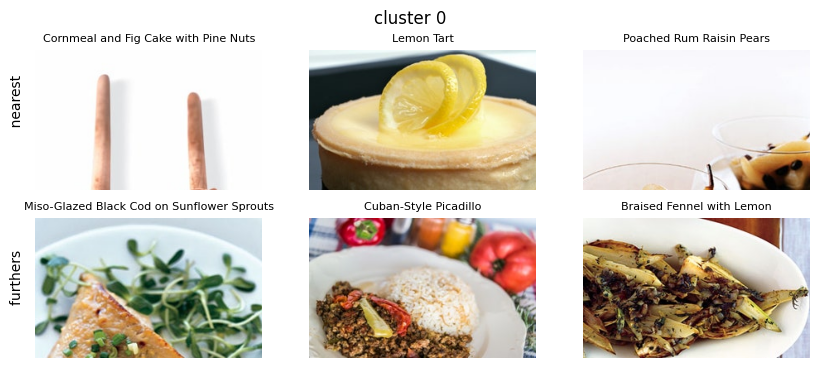

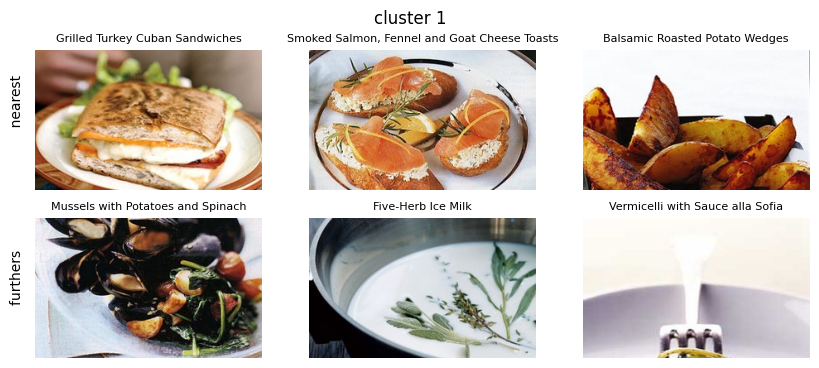

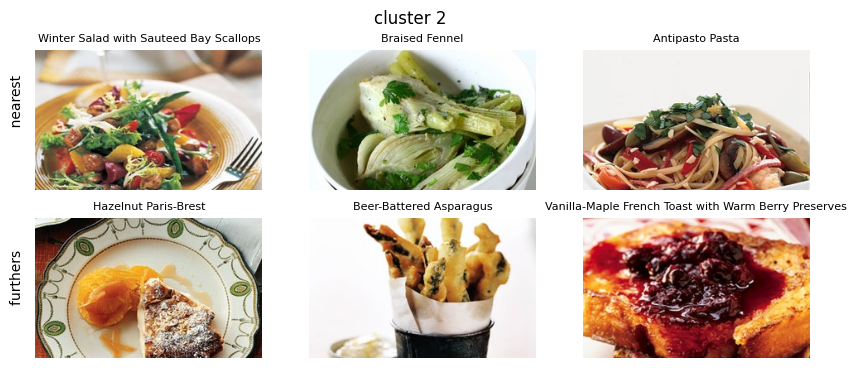

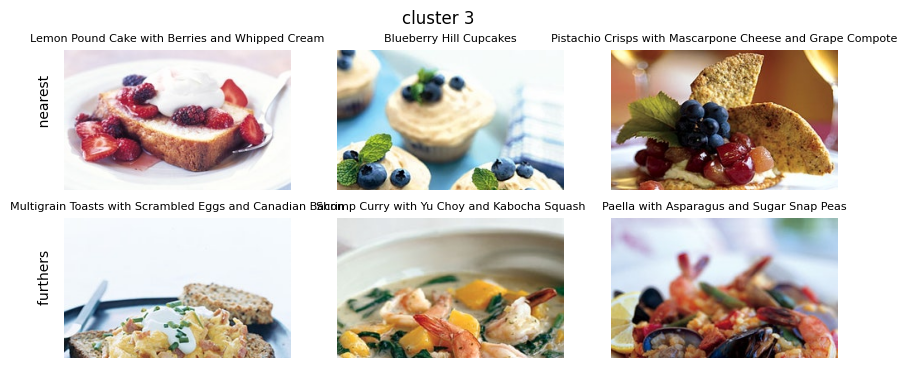

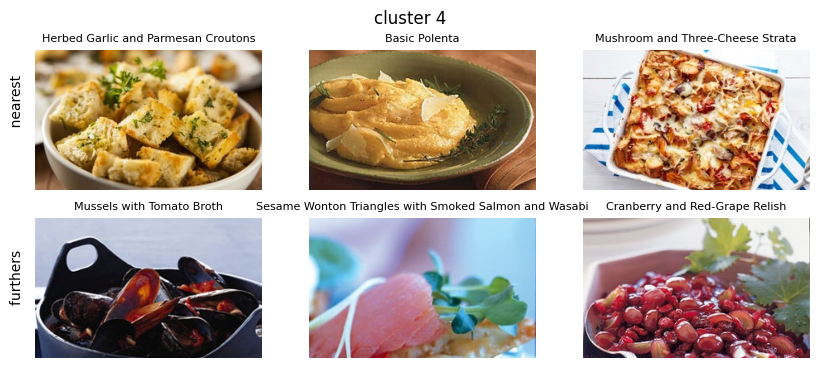

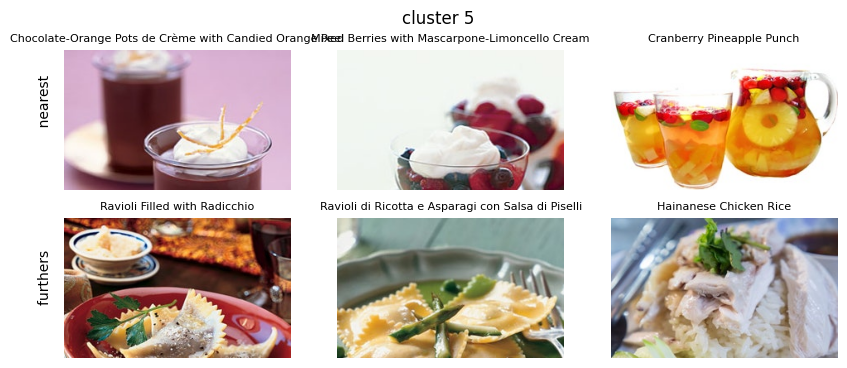

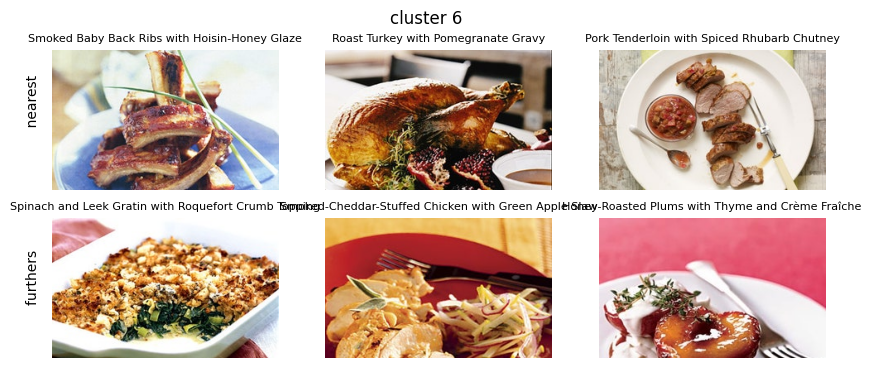

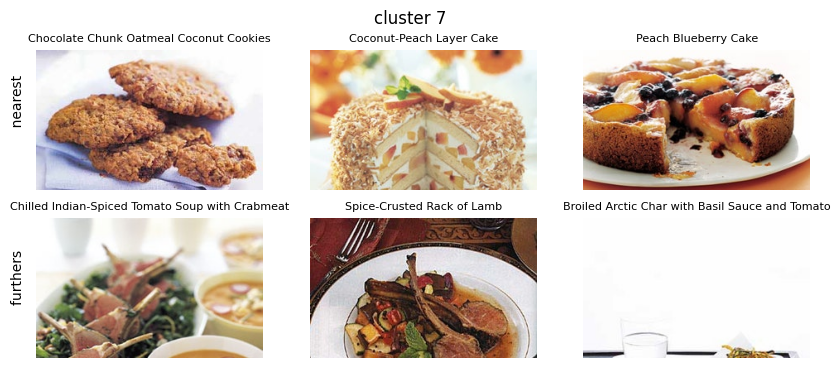

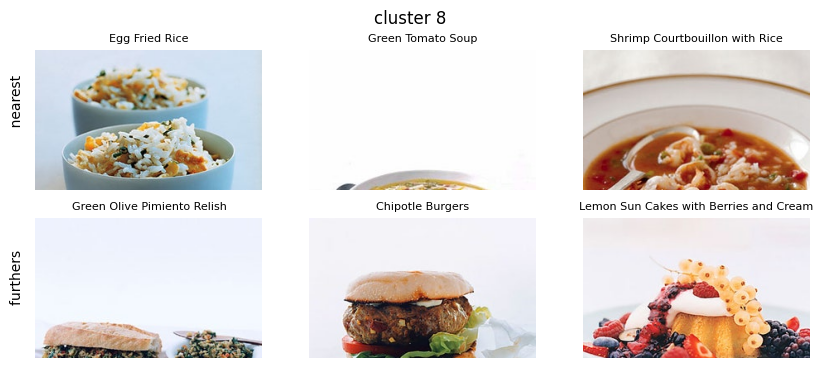

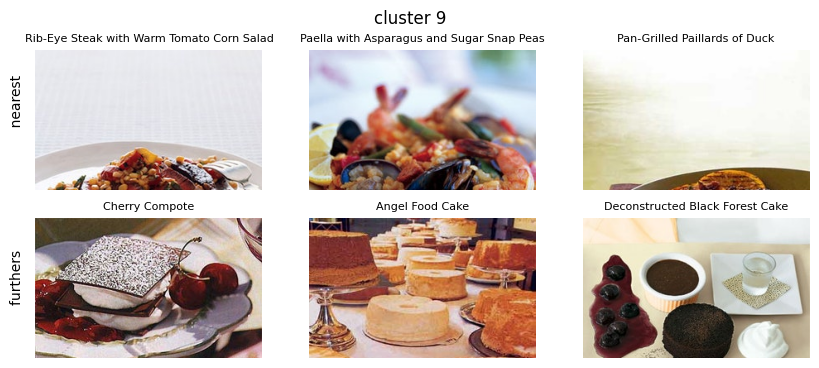

In [13]:
dist_to_cluster = Kmeans_model_img.transform(img_embs)


top_x_of_each_cluster = 3

color_fuckery = True # for some reason adding axis and fig lables inverts som of the colors
for cluster in range(n_clusters):
    cur_cluster = dist_to_cluster[:, cluster]
    cur_cluster_arg_sort = np.argsort(cur_cluster)
    best_idx = cur_cluster_arg_sort[:top_x_of_each_cluster]
    worst_idx = cur_cluster_arg_sort[-top_x_of_each_cluster:]

    fig, axes = plt.subplots(nrows=2, ncols=top_x_of_each_cluster, figsize=(10,4))
    fig.suptitle(f"cluster {cluster}")
    for i, idx in enumerate(best_idx): 
        food_pic = data_set_NO_transf[idx][0]
        axes[0, i].imshow(food_pic)
        axes[0, i].axis("off")
        if color_fuckery: axes[0, i].set_title(data_set_NO_transf[idx][1][0], fontsize=8)
    

    for i, idx in enumerate(worst_idx): 
        food_pic = data_set_NO_transf[idx][0]
        axes[1, i].imshow(food_pic)
        axes[1, i].axis("off")
        if color_fuckery: axes[1, i].set_title(data_set_NO_transf[idx][1][0], fontsize=8)
    #axes[1, 0].set_ylabel("worst")
    if color_fuckery: fig.text(0.1,0.25, "furthers                            nearest", rotation=90)
    plt.show()


    
